In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import os

from fractions import Fraction
import functools
import math

from Bio import Entrez
Entrez.email = "halabikeren@mail.tau.ac.il"

In [2]:
agg_networks_dir = "../../data/networks/all2/"

all_binary_networks_dir = f"{agg_networks_dir}/binary/"
os.makedirs(all_binary_networks_dir, exist_ok=True)

all_weighted_networks_dir = f"{agg_networks_dir}/weighted/"
os.makedirs(all_weighted_networks_dir, exist_ok=True)

sources = ["iwdb", "literature", "mangal", "web_of_life"]

In [3]:
# unzip dirs if neccessary
for source in sources:
    zip_path = f"../data/networks/{source}.zip"
    if os.path.exists(zip_path):
        res = os.system(f"cd ../../data/networks;unzip -o {source}.zip")

In [ ]:
def is_binary(network: pd.DataFrame) -> bool:
    cond1 = np.all(network.set_index("Plant").fillna(0).to_numpy() % 1 == 0)
    cond2 = np.all(network.set_index("Plant").fillna(0).to_numpy() <= 1)
    return cond1 and cond2

def need_transpose(network: pd.DataFrame, output_path:str):
    row_sp = network.Plant.tolist()
    taxids = []
    for sp in row_sp:
        try:
            taxid = Entrez.read(Entrez.esearch(term=sp, db="taxonomy", retmode="xml"))["IdList"][0]
            taxids.append(taxid)
        except Exception as e:
            continue
        if len(taxids) > 1:
            break
    if len(taxids) == 0:
        print(f"could not extract taxids for the network in {output_path}")
        return False
    try:
        tax_data = list(Entrez.parse(Entrez.efetch(id=",".join(taxids), db="taxonomy", retmode="xml")))
        tax_lineage_data = tax_data[0]["LineageEx"]
        for item in tax_lineage_data:
            if item["Rank"] == "kingdom" and item["ScientificName"] != "Viridiplantae":
                return True
    except:
        return False
    return False

unresolved_plant_names, unresvoled_pollinator_names = [], []
num_binary_networks, num_weigted_networks = 0, 0
bin_i, weighted_i = 0, 0
networks = dict()
network_metadata = pd.DataFrame(columns=["orig_path", "network_type", "network_index"])
for source in sources:
    binary_networks_paths = [f"../../data/networks/{source}/binary/{path}" for path in os.listdir(f"../../data/networks/{source}/binary/") if path.endswith(".csv") and "reference" not in path]
    num_binary_networks += len(binary_networks_paths)
    weighted_networks_paths = [f"../../data/networks/{source}/weighted/{path}" for path in os.listdir(f"../../data/networks/{source}/weighted/") if path.endswith(".csv") and "reference" not in path]
    num_weigted_networks += len(weighted_networks_paths)
    print(f"source = {source}, #binary networks = {len(binary_networks_paths)}, #weighted networks = {len(weighted_networks_paths)}")
    for network_path in list(binary_networks_paths + weighted_networks_paths):
        
        network = pd.read_csv(network_path)
        is_bin = is_binary(network)
        if is_bin:
            output_path = f"{all_binary_networks_dir}{bin_i}.csv"
            bin_i += 1
        else:
            output_path = f"{all_weighted_networks_dir}{weighted_i}.csv"
            weighted_i += 1
        network_columns = network.columns.tolist()
        plant_colname = [col for col in network.columns.tolist() if network[col].dtype == object][0]
        network.rename(columns={plant_colname: "Plant"}, inplace=True)
        network = network.loc[~network.Plant.str.lower().isin(["unknown", "total", "sorted_order"])]
        network.dropna(subset=["Plant"], inplace=True)
        if "Abundance" in network.columns:
            network.drop(["Abundance"], axis=1, inplace=True)
        network = network.query("not 'abundance' in Plant")
        if "Number of flowers" in network.columns:
            network.drop(["Number of flowers"], axis=1, inplace=True)
        for col in network.columns:
            if col != "Plant":
                network[col] = network[col].astype(np.float64)
                
        if len(network.Plant.tolist()) > len(network.Plant.unique()):
            network = network.groupby("Plant").sum().reset_index()
            
        if need_transpose(network, output_path):
            print(f"need to transpose network {output_path}")
            network = network.rename(columns={"Plant": "index"}).set_index("index").transpose().reset_index().rename(columns={"index":"Plant"})
        
        orig_sum = network.set_index("Plant").sum().sum()
        network.set_index('Plant', inplace=True)
        if not np.all(network.replace(np.nan, 0) % 1 == 0): # convert frequencies to numbers
            print(f"{output_path} required modification of interaction values to intger numbers")
            nums = pd.Series((network % 1).replace(0, np.nan).to_numpy().flatten()).dropna()
            fracs = [Fraction(x).limit_denominator() for x in nums]
            denoms = [f.denominator for f in fracs]
            factor = functools.reduce(lambda a,b: a*b//math.gcd(a,b), denoms)
            if factor > 10:
                print(f"warning, large scaling factor for {network_path}: {factor}")
            try:
                network = network * factor
            except Exception as e:
                print(f"could not transform network due to error {e}")
                continue
            network.reset_index(inplace=True)
        network.reset_index(inplace=True)
        network.Plant = network.Plant.apply(lambda x: x.replace("_", " "))
        
        if "cap.ata" in network.Plant.tolist():
            print(f"network {network_path} with output path {output_path} has plant code names")
        
        network.fillna(0, inplace=True)
        
        if  np.any(network.sum(axis=0) == 0):
            network.set_index("Plant", inplace=True)
            network = network.loc[:,network.sum(axis=0)>0]
            network.reset_index(inplace=True)
            
        if np.any(network.sum(axis=1) == 0):
            print(f"{output_path} - removing pollinators with no interactions from network")
            network.set_index("Plant", inplace=True)
            network = network.loc[network.sum(axis=1)>0]
            network.reset_index(inplace=True)
        
        networks[os.path.basename(network_path)] = network
        network = np.rint(network.set_index("Plant")).astype(np.int16).reset_index()
        
        network_metadata = pd.concat([network_metadata, pd.DataFrame({"orig_path": [network_path],
                                                                      "network_type": ['binary' if is_bin else 'weighted'],
                                                                      "network_index": [bin_i if is_bin else weighted_i]})])
        if network.set_index("Plant").sum().sum() == 0:
            print(f"warning! network {network_path} has no interactions! original sum was {orig_sum}")
        
        network.to_csv(output_path, index=False)
        unresolved_plant_names += network.Plant.tolist()
        unresvoled_pollinator_names += list(set(network.columns) - {"Plant"})

network_metadata.to_csv(f"{agg_networks_dir}/networks_metadata.csv", index=False)
print(f"# binary networks = {bin_i}\n# weighted networks = {weighted_i}\n# networks = {bin_i + weighted_i}")

source = iwdb, #binary networks = 2, #weighted networks = 8


In [4]:
unresolved_plant_names = list(set(unresolved_plant_names))
print(f"# unresolved plant names = {len(unresolved_plant_names)}")
pd.DataFrame({"Id": list(range(1, len(unresolved_plant_names)+1)), "Name": unresolved_plant_names}).to_csv(f"../name_resolution/unresolved_plant_names.csv", index=False)

# unresolved plant names = 5319


In [5]:
unresvoled_pollinator_names = list(set(unresvoled_pollinator_names))
print(f"# unresolved pollinator names = {len(unresvoled_pollinator_names)}")
pd.DataFrame({"Id": list(range(1, len(unresvoled_pollinator_names)+1)), "Name": unresvoled_pollinator_names}).to_csv(f"../name_resolution/unresolved_pollinator_names.csv", index=False)

# unresolved pollinator names = 14785


In [6]:
network_stats = pd.DataFrame(columns=["network", "num_plants", "num_pollinators"])
network_stats["network"] = pd.Series(networks.keys())
network_stats["num_plants"] = network_stats["network"].apply(lambda path: networks[path].shape[0])
network_stats["num_pollinators"] = network_stats["network"].apply(lambda path: networks[path].shape[1])

<AxesSubplot:ylabel='Frequency'>

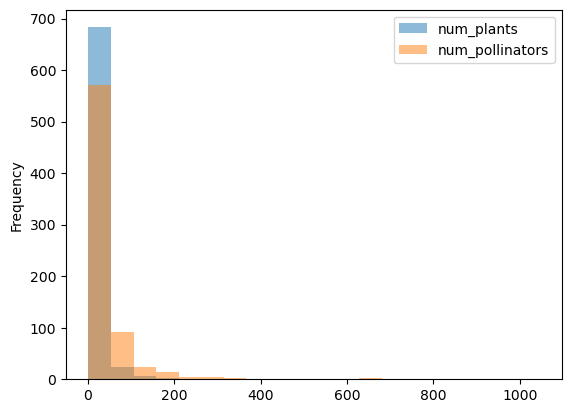

In [7]:
network_stats.plot(kind='hist', bins=20, stacked=False, alpha=.5)

In [8]:
network_stats["num_total"] = network_stats.num_plants + network_stats.num_pollinators
network_stats["mult_total"] = network_stats.num_plants * network_stats.num_pollinators
metadata.loc[network_stats.num_total == network_stats.num_total.max()]

,network,num_plants,num_pollinators,num_total,mult_total
717,M_PL_062.csv,456,1045,1501,476520


In [ ]:
# remove unzipped dirs
for source in sources:
    src_dir = f"../data/networks/{source}/"
    os.remove(src_dir)